## Analysis of Pitchfork album reviews

The dataset contains 26404 album reviews, released on the online magazine Pitchfork over the course of 25 years (1999 - 2024).

### 0 - Imports

In [138]:
import pandas as pd
import numpy as np 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

reviews = pd.read_csv('../dataset/pitchfork_album_reviews.csv')

### 1 - Data structure & quality investigation

#### 1.1 - General shape and dtypes

In [139]:
reviews.shape

(26404, 14)

In [3]:
reviews.head()

,review_id,album_name,artist,genre,label,release_year,score,best_new_music,reviewer_name,review_date_day,review_date_month,review_date_year,review_length,cover_url
0,1,Malegría,Reyna Tropical,Pop/R&B / Folk/Country,Psychic Hotline,2024.0,7.7,0,Isabelia Herrera,11,4,2024,796,https://media.pitchfork.com/photos/66030d16459...
1,2,Ohio Players,The Black Keys,Rock,Nonesuch,2024.0,7.2,0,Stephen Thomas Erlewine,5,4,2024,771,https://media.pitchfork.com/photos/659fe1acc4c...
2,3,Might Delete Later,J. Cole,Rap,Interscope,2024.0,5.1,0,Paul A. Thompson,10,4,2024,808,https://media.pitchfork.com/photos/66100870006...
3,4,Las Mujeres Ya No Lloran,Shakira,Pop/R&B,Sony Music Latin,2024.0,7.0,0,Boutayna Chokrane,4,4,2024,1075,https://media.pitchfork.com/photos/65ce1f9ee2c...
4,5,Marciology,Roc Marciano,Rap,Pimpire International / Marci Enterprises,2024.0,8.1,0,Dash Lewis,3,4,2024,1093,https://media.pitchfork.com/photos/6605b487696...


In [3]:
reviews['release_year'] = reviews.release_year.astype('Int64')


#### 1.2 - Duplicates

In [5]:
reviews.duplicated(reviews.columns[1:]).sum()

5

5 duplicate rows that must be dropped.

In [5]:
reviews = reviews.drop_duplicates(reviews.columns[1:])

#### 1.3 - Missing values

In [6]:
reviews.isna().sum()

review_id               0
album_name            606
artist                606
genre                2370
label                 659
release_year         1015
score                   0
best_new_music          0
reviewer_name        1144
review_date_day         0
review_date_month       0
review_date_year        0
review_length           0
cover_url             608
dtype: int64

<Axes: >

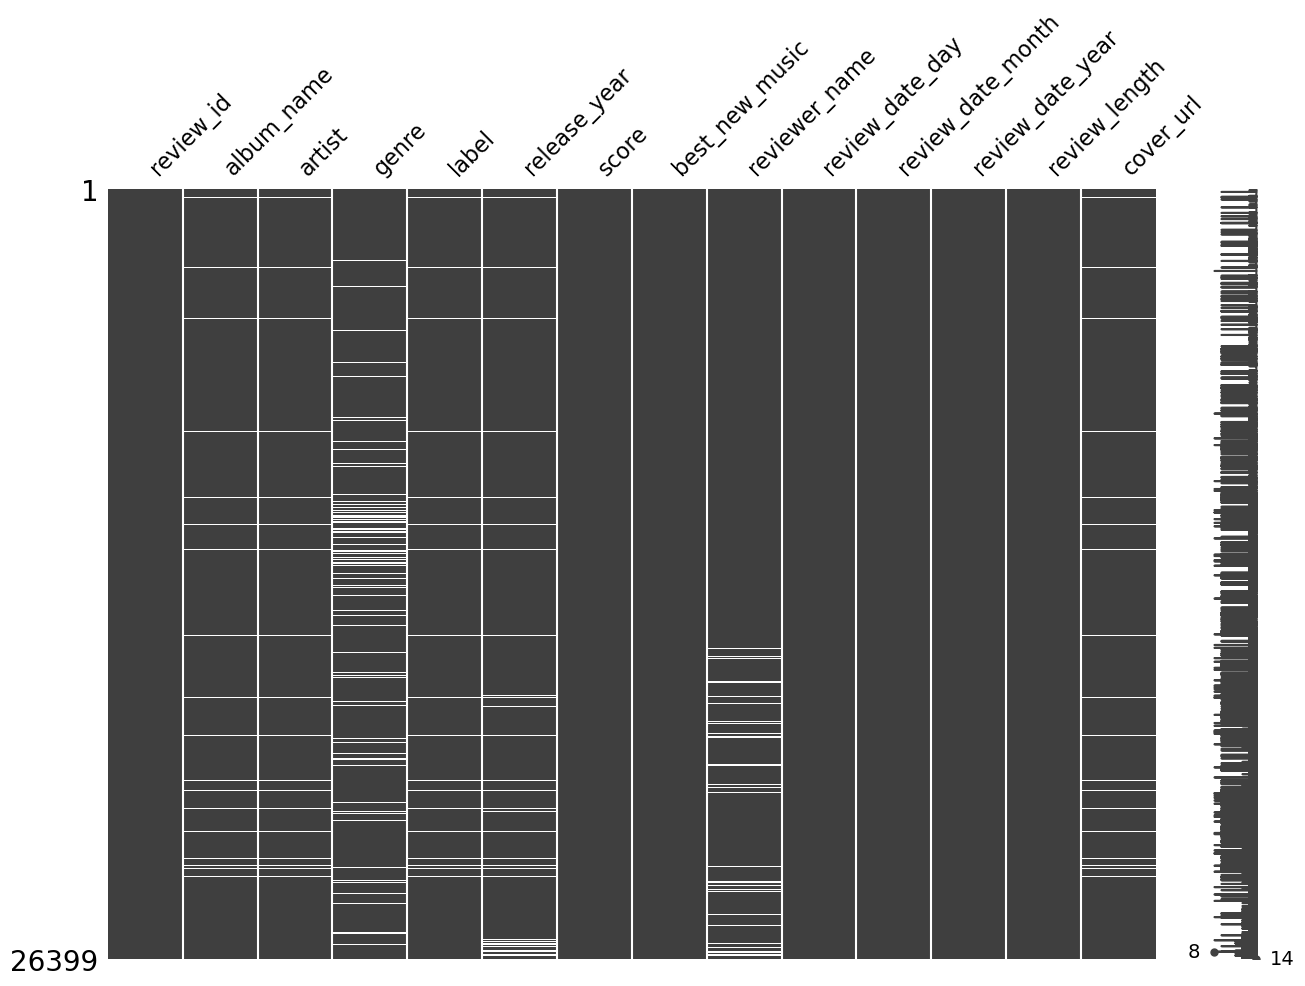

In [7]:
msno.matrix(reviews, figsize=(15,10))

Multiple missing values due to scraping difficulties. 
- *Album name*, *artist*, *release year*, and *reviewer name* missing values cannot really be filled without the use of external data.
- *Genre* and *label* could be filled by approximating the values based on the other columns : an artist generally releases the same kind of music, so the genre could be inferred using this feature, the same reasoning could be applied to the label.

#### 1.4 - Unwanted values

The scraping process let through some unwanted values, for example the genre column which contains on a few occasions the review itself :

In [16]:
reviews_genre = reviews.dropna(subset=['genre'])
reviews_genre.loc[reviews_genre.genre.str.startswith('Osborn')]

,review_id,album_name,artist,genre,label,release_year,score,best_new_music,reviewer_name,review_date_day,review_date_month,review_date_year,review_length,cover_url
11043,11044,This Machine Kills Artists,"Buzz ""King Buzzo"" Osborne","Osborne's flirtations with folk are, essential...",Ipecac,2014,6.4,0,Jason Heller,4,6,2014,538,https://media.pitchfork.com/photos/5929a7f6c00...


In these cases, we can just set the genre value to None instead of deleting the whole rows :

In [59]:
indices = [reviews_genre.loc[reviews_genre.genre.str.startswith('Osborn')].index[0],
           reviews_genre.loc[reviews_genre.genre.str.startswith('But wait')].index[0],
           reviews_genre.loc[reviews_genre.genre.str.startswith('That familial')].index[0], ]
reviews.loc[indices, 'genre'] = np.nan

### 2 - Analysis

#### 2.1 - How many albums were certified Best New Music every year ? 

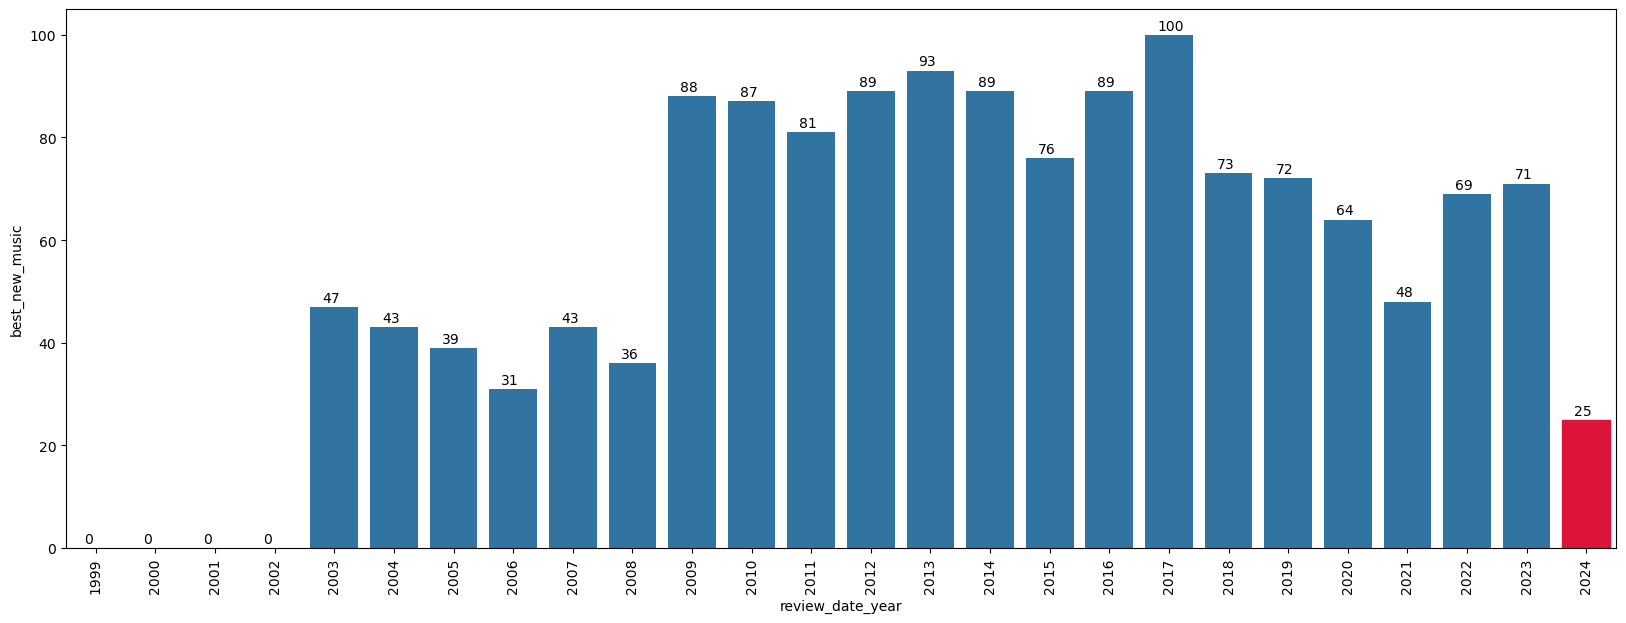

In [128]:
plt.figure(figsize=(20,7))
ax = sns.barplot(reviews.groupby('review_date_year')['best_new_music'].sum())
ax.patches[-1].set_color('crimson')
for patch in ax.patches:
    ax.annotate(str(int(patch.get_height())), (patch.get_x()+0.2, patch.get_height() + 1))
plt.xticks(rotation=90)
plt.show()

- 2017, as I remember it, was a year full of amazing album releases: from Sza's Ctrl to Kelela's Tame Apart, passing by LCD Soundsystem's American dream. I am not surprised to see it rank as the year with the most Best New Music releases from Pitchfork's perspective.
- 2024's data is not to be compared to the other as the dataset is only 3 months and a half into the year.

#### 2.2 - Which artists had the most Best New Music releases ? 

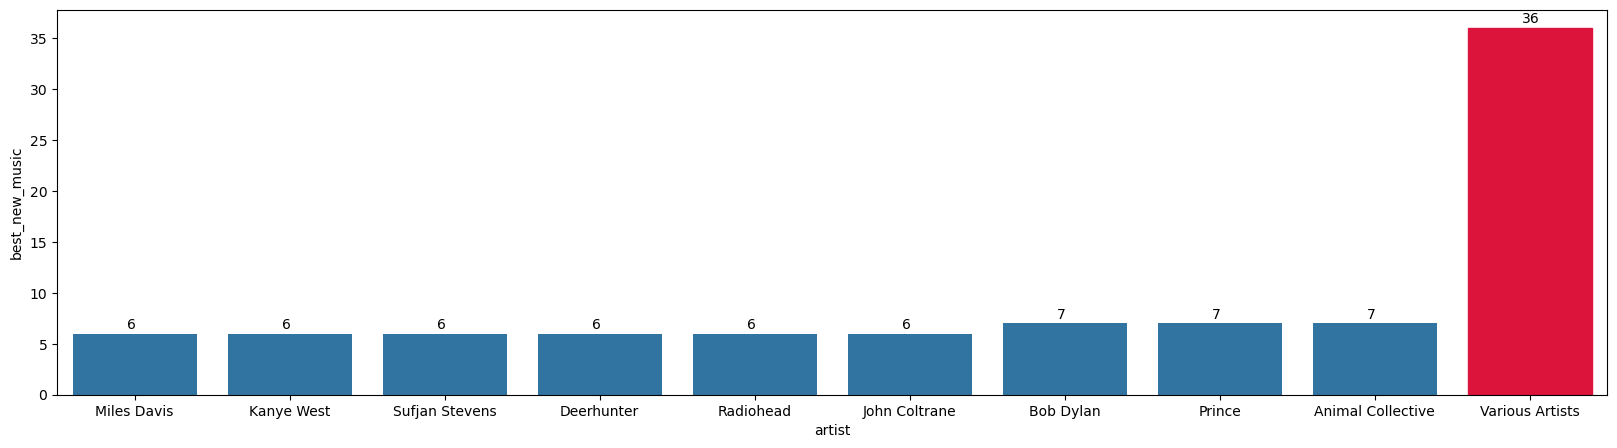

In [154]:
plt.figure(figsize=(20,5))
ax = sns.barplot(reviews.groupby('artist').best_new_music.sum().sort_values(ascending=False).head(10)[::-1])
ax.patches[-1].set_color('crimson')
for patch in ax.patches:
    ax.annotate(str(int(patch.get_height())), (patch.get_x()+0.35, patch.get_height() + 0.5))
plt.show()

#### 2.3 - Which labels had the most Best New Music releases ? 

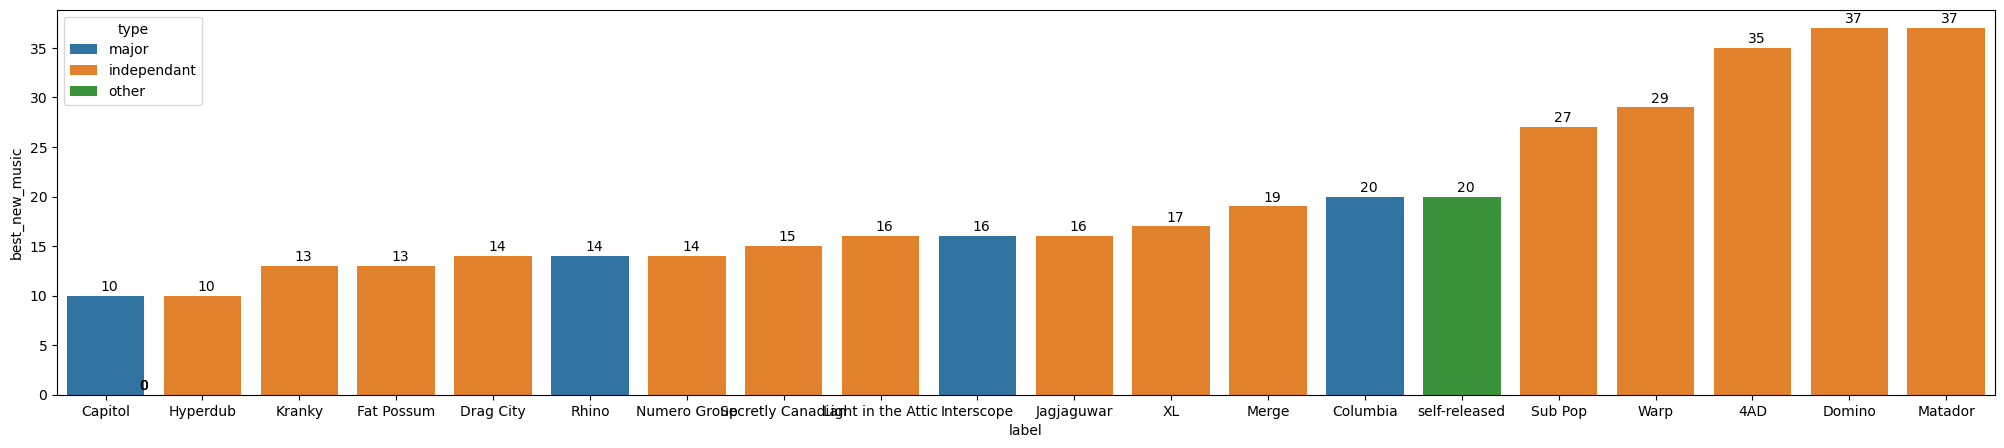

In [27]:
major_labels_list = ["Columbia", "Interscope", "Rhino", "Capitol"]
independant_labels_list = ["Matador", "Domino", "Warp", "Sub Pop", "XL", "Merge", "Island Records", "4AD", "Jagjaguwar", "Light in the Attic", "Secretly Canadian", "Numero Group", "Drag City", "Fat Possum", "Kranky", "Hyperdub"]

plt.figure(figsize=(25,5))
grouped_label = reviews.groupby('label').best_new_music.sum().sort_values(ascending=False).head(20)[::-1].reset_index()
grouped_label['type'] = grouped_label.label.apply(lambda x: 'independant' if x in independant_labels_list else 'major' if x in major_labels_list else 'other')
ax = sns.barplot(grouped_label, x="label", y="best_new_music", hue='type', palette="tab10")
for patch in ax.patches:
    ax.annotate(str(int(patch.get_height())), (patch.get_x()+0.35, patch.get_height() + 0.5))

plt.show()

Pitchfork kinda loves independant music, and so do I.

#### 2.4 - What is the scores distribution by genre ? 

<Axes: xlabel='score', ylabel='Density'>

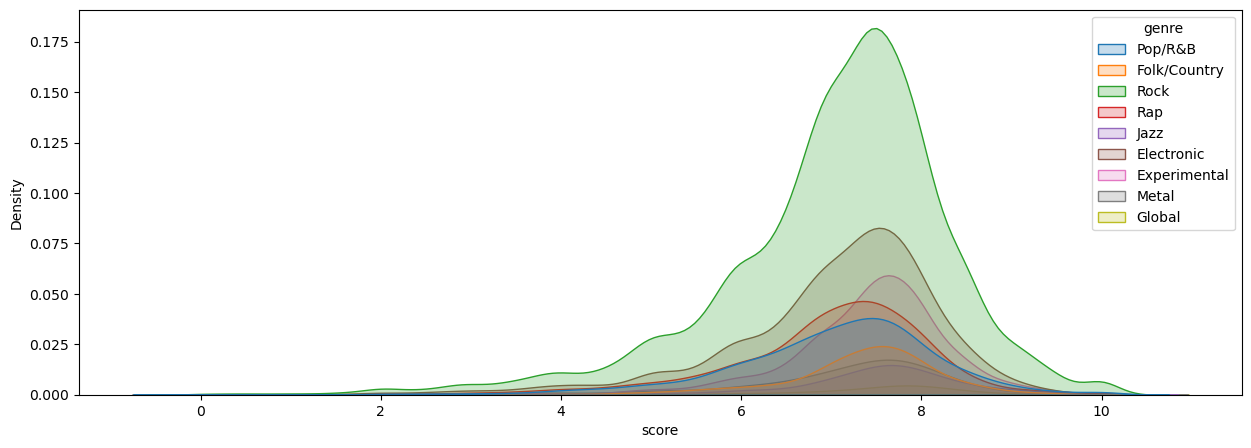

In [131]:
reviews_genre = reviews.copy()
reviews_genre['genre'] = reviews.genre.str.split(' / ')
reviews_genre = reviews_genre.explode('genre').reset_index(drop=True)

plt.figure(figsize=(15,5))
sns.kdeplot(reviews_genre, x="score", hue="genre", fill=True) 

#### 2.5 - Do reviewers write longer reviews for albums they love ? 

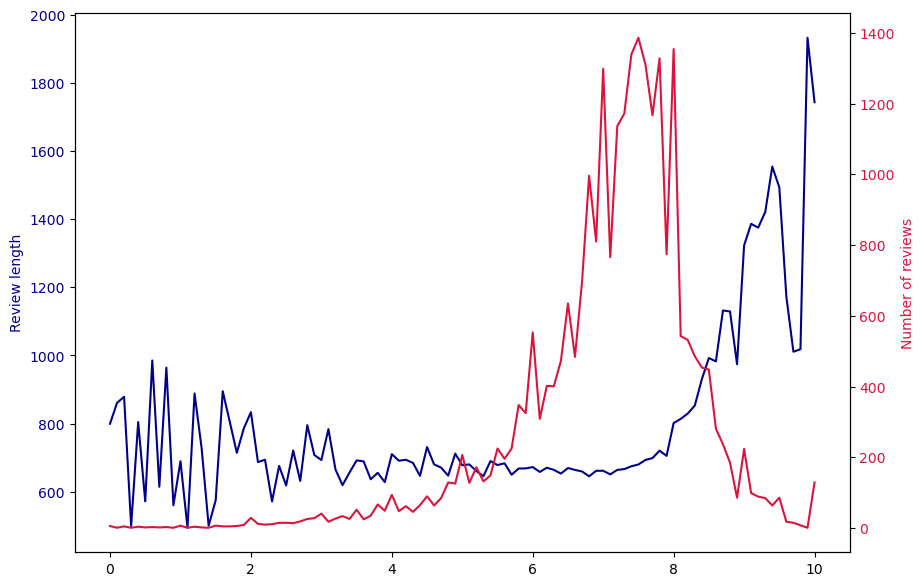

In [135]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax2 = ax1.twinx()

ax1.plot(reviews[['score', 'review_length']].groupby('score').mean(), color='darkblue')
ax2.plot(reviews[['score', 'review_length']].groupby('score').count(), color='crimson')

ax1.set_ylabel('Review length', color='darkblue')
ax1.tick_params(axis="y", labelcolor='darkblue')
ax2.set_ylabel('Number of reviews', color='crimson')
ax2.tick_params(axis="y", labelcolor='crimson')
plt.show()

Yep they clearly do.